# 2. Texts classification (binary classification)

Тестовое задание в компанию [**Automacon**](https://automacon.ru/).

**Исходные данные:** [link](https://www.kaggle.com/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset)

**Задача:** обучить две модели классификации текстов для каждого из датасетов.

В данном ноутбуке рассмотрена работа со вторым датасетом для бинарной классификации текстов.

## Imports

In [1]:
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from termcolor import colored
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import torch
from torch.utils.data import DataLoader

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer, 
    TrainingArguments,
)

from datasets import Dataset, DatasetDict
import evaluate

In [2]:
pd.set_option('display.max_colwidth', 100)

sns.set_style('whitegrid')
sns.set_palette('muted')

## Functions

In [3]:
def torch_device() -> str:
    """Вовзращает строку 'cuda' при наличии оборудования, иначе 'cpu'."""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"torch use: {colored(device, 'green', attrs=['bold'])}", 
          f"({torch.cuda.get_device_name()})"
          if torch.cuda.is_available() else "")
    return device

In [4]:
def df_info(df: pd.DataFrame):
    """Вывод первых строк таблицы pandas и количества пропусков для каждой колонки."""
    display(df.head())
    print(colored('Shape:', attrs=['bold']), df.shape, '\n')
    print(colored('Missing values:', attrs=['bold']))
    print(df.isna().sum().to_string(index=True))

In [5]:
def hist_box_chart(data: list[float | int], title: str | None = None) -> None:
    """Построение гистограммы и boxplot для списка значений."""
    fig, ax = plt.subplots(2, figsize=(11, 3.5), sharex=True, gridspec_kw={"height_ratios": (1, .15)})
    
    sns.histplot(data=data, ax=ax[0], kde=True, bins=min(150, np.unique(data).shape[0]), stat='density')
    ax[0].axvline(x=np.median(data), color='black', alpha=.5, label=f'median ({np.median(data):.2f})')
    ax[0].axvline(x=np.mean(data), color='black', alpha=.5, label=f'mean ({np.mean(data):.2f})', linestyle='dashed')
    ax[0].set(title=title, xlabel='', ylabel='')
    ax[0].legend()

    sns.boxplot(data=data, ax=ax[1], boxprops={'alpha': .5}, orient='y')
    ax[1].set(xlabel='count', ylabel='')

In [6]:
class Ansi:
    bold = '\033[1m'
    end = '\033[0m'

def get_model_size(model) -> str:
    """Вывод размера модели в миллионах параметров."""
    model_size = sum(p.numel() for p in model.parameters()) / 1e6
    model_size_train = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
    print(f"Model_size: {Ansi.bold}{model_size:.2f}{Ansi.end}M params", end='')

    if model_size_train < model_size:
        print(f" || Trainable params: {Ansi.bold}{model_size_train:.2f}{Ansi.end}M "
              f"({Ansi.bold}{model_size_train / model_size:.4%}{Ansi.end})")


def get_requires_grad(model, detail=True, only_true=False) -> str:
    """Вывод названий слоев модели для которых 'разморожены' градиенты."""
    params = {name: p.requires_grad for name, p in model.named_parameters()}
    params = pd.Series(params)

    get_model_size(model)

    print(f"\n{Ansi.bold}Requires grad:{Ansi.end}")
    print(f"True:  {Ansi.bold}{params.sum()}{Ansi.end}")
    print(f"False: {Ansi.bold}{(~params).sum()}{Ansi.end}")

    if detail:
        print()
        if only_true:
            print(params[params].to_string(index=True))
        else:
            print(params.to_string(index=True))


In [7]:
SEED = 42
DEVICE = torch_device()

torch use: cuda (AMD Radeon RX 7800 XT)


In [8]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## Load data

Загружаем данные.

In [9]:
data = pd.read_csv('combined_sentiment_data.csv')

In [10]:
df_info(data)

,sentence,sentiment
0,So there is no way for me to plug it in here in the US unless I go by a converter.,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,negative
4,The mic is great.,positive


Shape: (3309, 2) 

Missing values:
sentence     0
sentiment    0


Датасет довольно небольшой. Пропущенных значений в данных нет. Проверим наличие дубликатов.

In [11]:
print('Количество полных дубликатов:', data.duplicated().sum())
print('Количество дубликатов в столбце sentence:', data['sentence'].duplicated().sum())

Количество полных дубликатов: 19
Количество дубликатов в столбце sentence: 20


В данных присутствует некоторое количество дублей. Удалим их.

In [12]:
data = data.drop_duplicates(subset=['sentence'])

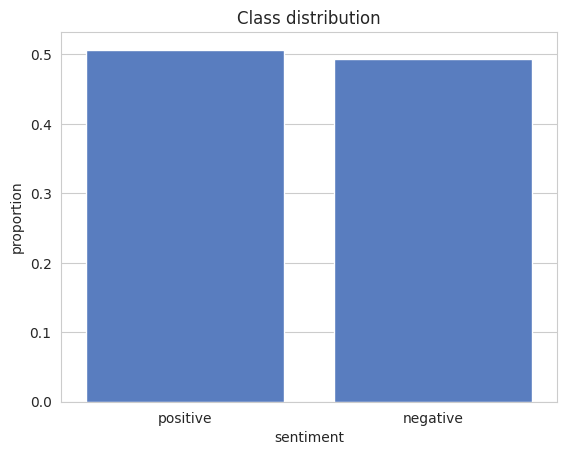

In [13]:
sns.barplot(data['sentiment'].value_counts(normalize=True))
plt.title('Class distribution')
plt.show()

Соотношение классов практически 50 на 50.

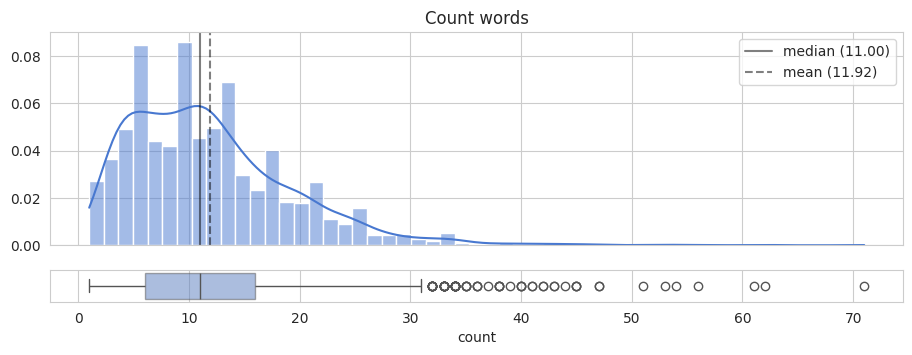

In [14]:
cnt_words = [len(text.split()) for text in data['sentence'].tolist()]

hist_box_chart(cnt_words, 'Count words')

Средняя длина текста составляет примерно 12 слов. На графике присутствуют выбросы с правой стороны, это говорит о присутствии в выборке некоторого количество относительно длинных текстов.

Составим словари для преобразования названия класса в индекс и обратно.

In [15]:
id2label = {k: v for k, v in enumerate(sorted(data['sentiment'].unique()))}
label2id = {v: k for k, v in id2label.items()}

print(id2label)

{0: 'negative', 1: 'positive'}


Целевой признак представим в виде числовых значений.

In [16]:
data['sentiment'] = data['sentiment'].apply(lambda x: label2id[x])
data = data.rename(columns={'sentiment': 'label'})
data.head()

,sentence,label
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


## Dataset

Разделим исходный датасет на 3 выборки: train, val, test; в соотношении **70-15-15**.

In [17]:
train_data, val_test_data = train_test_split(
    data, 
    test_size=.3, 
    shuffle=True, 
    random_state=SEED, 
    stratify=data['label']
)

val_data, test_data = train_test_split(
    val_test_data, 
    test_size=.5, 
    shuffle=True, 
    random_state=SEED, 
    stratify=val_test_data['label']
)

In [18]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_data, preserve_index=False),
    'val': Dataset.from_pandas(val_data, preserve_index=False),
    'test': Dataset.from_pandas(test_data, preserve_index=False),
})

dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2302
    })
    val: Dataset({
        features: ['sentence', 'label'],
        num_rows: 493
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 494
    })
})

Будем использовать модель [**clapAI/modernBERT-base-multilingual-sentiment**](https://huggingface.co/clapAI/modernBERT-base-multilingual-sentiment), которая обучена на задачу sentiment analysis для классификации на 3 класса: Negative, Neutral, Positive. Т.к. нам достаточно только двух классов, то переопределим выходной классификационный слой.

In [19]:
model_name = 'clapAI/modernBERT-base-multilingual-sentiment'

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2, 
    ignore_mismatched_sizes=True, 
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

get_model_size(model)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at clapAI/modernBERT-base-multilingual-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model_size: 149.61M params

Токенезируем тексты в датасете.

In [20]:
def tokenize_function(example):
    return tokenizer(example['sentence'], truncation=True)

dataset_tokenize = dataset.map(tokenize_function, batched=True)
dataset_tokenize = dataset_tokenize.remove_columns(['sentence'])

collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/2302 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

## Train

Т.к. наш датасет скромных размеров, то попытка обучения всей модели непременно приведет к переобучению.  
Можно использовать дополнительные адаптеры, например LoRA иди Prefix-tune. Но так как задача sentiment analysis довольно распространенная, то предобученные модели справляются с ней уже достаточно хорошо. В нашем случае будет достаточно дообучить классификационный слой.

In [21]:
model.requires_grad_(False)
model.classifier.requires_grad_(True)

get_requires_grad(model, only_true=True)

Model_size: 149.61M params || Trainable params: 0.00M (0.0010%)

Requires grad:
True:  2
False: 136

classifier.weight    True
classifier.bias      True


Во время обучения будем отслеживать метрику `accuracy`.

In [22]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [23]:
training_args = TrainingArguments(
    output_dir="./binary",
    overwrite_output_dir=True,
    save_total_limit=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=1,
    lr_scheduler_type='cosine',
    warmup_steps=20,
    fp16=True,
    learning_rate=4e-4,
    weight_decay=.01,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenize["train"],
    eval_dataset=dataset_tokenize["val"],
    data_collator=collator,
    compute_metrics=compute_metrics,
)

In [24]:
gc.collect()
torch.cuda.empty_cache()

trainer.train()

/home/lake/anaconda3/envs/lime_test/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)
/home/lake/anaconda3/envs/lime_test/lib/python3.11/site-packages/transformers/models/modernbert/modeling_modernbert.py:436: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  F.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.501000,0.315435,0.906694
2,0.168900,0.200837,0.937120
3,0.306600,0.196981,0.939148
4,0.152900,0.197485,0.943205
5,0.209600,0.198698,0.945233
6,0.271500,0.199425,0.945233
7,0.085100,0.199888,0.945233
8,0.339600,0.199763,0.945233
9,0.189200,0.199940,0.945233
10,0.254500,0.199944,0.945233


TrainOutput(global_step=180, training_loss=0.31337202220327326, metrics={'train_runtime': 38.081, 'train_samples_per_second': 604.5, 'train_steps_per_second': 4.727, 'total_flos': 750826636562856.0, 'train_loss': 0.31337202220327326, 'epoch': 10.0})

Уже на 5 эпохе было достигнуто лучшее значение метрики Accuracy, которое до конца обучения осталось неизменным.

## Test

Перейдем к тестированию полученной модели.

Для начала определим вспомогательные функции для получения предсказаний и значений метрик.

In [25]:
def get_predict(model, dataloader, device):
    predictions = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='predictions'):
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            pred = torch.argmax(logits, dim=1).cpu()
            predictions.append(pred)

    return torch.cat(predictions)

In [26]:
def get_metrics(ground_truth, predictions, title: str):
    print(colored(title.upper().center(60, '-'), 'light_blue', attrs=['bold']))
    print(classification_report(ground_truth, 
                                predictions, 
                                digits=4, 
                                target_names=list(label2id.keys())
                                ))

    _, ax = plt.subplots(figsize=(2.5, 2.5))
    ConfusionMatrixDisplay.from_predictions(
        ground_truth, 
        predictions, 
        ax=ax, 
        cmap='Blues', 
        colorbar=False, 
        display_labels=list(label2id.keys())
    )
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

Сделаем 2 даталоудера для возможности итерации по батчам.

In [27]:
gt_val = dataset_tokenize['val']['label']
gt_test = dataset_tokenize['test']['label']

val_dataset = dataset_tokenize['val'].remove_columns('label')
test_dataset = dataset_tokenize['test'].remove_columns('label')

val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64, collate_fn=collator)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, collate_fn=collator)

Сделаем предсказания для валидационной и тестовой выборок.

In [28]:
pred_val = get_predict(model, val_loader, DEVICE)
pred_test = get_predict(model, test_loader, DEVICE)

predictions:   0%|          | 0/8 [00:00<?, ?it/s]

predictions:   0%|          | 0/8 [00:00<?, ?it/s]

Для начала взглянем на результаты для валидационного датасета.

---------------------VALIDATION DATASET---------------------
              precision    recall  f1-score   support

    negative     0.9355    0.9547    0.9450       243
    positive     0.9551    0.9360    0.9455       250

    accuracy                         0.9452       493
   macro avg     0.9453    0.9454    0.9452       493
weighted avg     0.9454    0.9452    0.9452       493



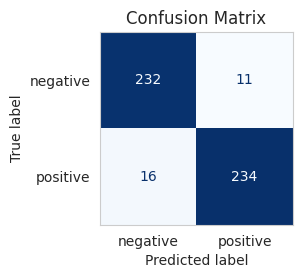

In [29]:
get_metrics(gt_val, pred_val, 'validation dataset')

На валидации получаем метрику `Accuracy` **0.9452**.  
Значения `Precision` и `Recall` получились достаточно близкими по значению, что говорит о том, что модель довольно стабильна и не имеет явного перекоса в сторону ложноположительных или ложноотрицательных предсказаний.

Теперь протестируем модель на отложенной тестовой выборке.

------------------------TEST DATASET------------------------
              precision    recall  f1-score   support

    negative     0.9673    0.9713    0.9693       244
    positive     0.9719    0.9680    0.9699       250

    accuracy                         0.9696       494
   macro avg     0.9696    0.9697    0.9696       494
weighted avg     0.9696    0.9696    0.9696       494



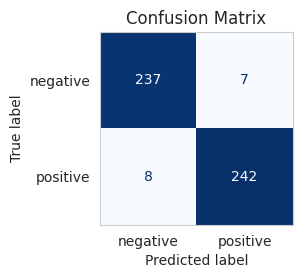

In [30]:
get_metrics(gt_test, pred_test, 'test dataset')

Метрика `Accuracy` на тестовой выборке получилась даже немного выше, чем на валидации, и составила **0.9696**, такое улучшение вероятно связано с тем, что наш датасет невелик и в тестовую часть попали более простые примеры.  
Ошибки False Positive и False Negative здесь так же распределились примерно поровну.